In [1]:
# Step 1: Import Required Libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm
import nibabel as nib
from PIL import Image
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Define a function to get file paths and labels from the directories.
def load_file_list(tumour_dir, non_tumour_dir):
    file_label_list = []
    # Label 1 for Tumour, Label 0 for Non Tumour
    for file in os.listdir(tumour_dir):
        if file.endswith('.nii.gz'):
            file_label_list.append((os.path.join(tumour_dir, file), 1))
    for file in os.listdir(non_tumour_dir):
        if file.endswith('.nii.gz'):
            file_label_list.append((os.path.join(non_tumour_dir, file), 0))
    return file_label_list

In [3]:
# Subject-level functions
def get_subject_id(filepath):
    """
    Extract a subject ID from a single file path.
    For example:
      'C:/.../UPENN-GBM-00003_1_T1.nii.gz' -> 'UPENN-GBM-00003_1'
      'C:/.../IXI228-Guys-0822-T1.nii.gz'  -> 'IXI228-Guys-0822'
    """
    filename = os.path.basename(filepath)
    core = filename.replace('.nii.gz', '')  # e.g., 'UPENN-GBM-00003_1_T1'
    # Split on '_T1' to remove the modality part. Adjust if needed.
    subject_id = core.split('_T1')[0]
    return subject_id

In [4]:
def get_subject_ids(file_list):
    """
    Loops through a list of (file_path, label) pairs,
    extracting the subject ID from each file_path.
    Returns a set of subject IDs.
    """
    subject_ids = set()
    for (filepath, _) in file_list:
        sid = get_subject_id(filepath)
        subject_ids.add(sid)
    return subject_ids

In [5]:
def group_by_subject(file_label_list):
    """
    Groups all (file_path, label) pairs by their subject ID.
    """
    subjects = defaultdict(list)
    for (fp, label) in file_label_list:
        sid = get_subject_id(fp)
        subjects[sid].append((fp, label))
    return subjects

In [6]:
def subject_level_split(file_label_list, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Splits the dataset at the subject level into train/val/test lists.
    Each subject's files are kept together in one split.
    """
    subjects_dict = group_by_subject(file_label_list)
    subject_ids = list(subjects_dict.keys())
    
    # Shuffle subject IDs
    random.seed(seed)
    random.shuffle(subject_ids)
    
    total_subjects = len(subject_ids)
    train_size = int(train_ratio * total_subjects)
    val_size = int(val_ratio * total_subjects)
    # Remaining go to test
    test_size = total_subjects - train_size - val_size
    
    train_subjects = subject_ids[:train_size]
    val_subjects   = subject_ids[train_size:train_size+val_size]
    test_subjects  = subject_ids[train_size+val_size:]
    
    train_list, val_list, test_list = [], [], []
    for sid in train_subjects:
        train_list.extend(subjects_dict[sid])
    for sid in val_subjects:
        val_list.extend(subjects_dict[sid])
    for sid in test_subjects:
        test_list.extend(subjects_dict[sid])
        
    return train_list, val_list, test_list

In [7]:
def check_duplicate_files(train_list, val_list, test_list):
    # Extract base filenames from the lists
    train_files = set([os.path.basename(f[0]) for f in train_list])
    val_files   = set([os.path.basename(f[0]) for f in val_list])
    test_files  = set([os.path.basename(f[0]) for f in test_list])
    
    overlap_train_val = train_files.intersection(val_files)
    overlap_train_test = train_files.intersection(test_files)
    overlap_val_test = val_files.intersection(test_files)
    
    print("File-Level Overlap:")
    print("Train-Validation:", len(overlap_train_val), overlap_train_val)
    print("Train-Test:", len(overlap_train_test), overlap_train_test)
    print("Validation-Test:", len(overlap_val_test), overlap_val_test)

In [8]:
def check_subject_overlap(train_list, val_list, test_list):
    train_ids = get_subject_ids(train_list)
    val_ids   = get_subject_ids(val_list)
    test_ids  = get_subject_ids(test_list)
    
    overlap_train_val  = train_ids.intersection(val_ids)
    overlap_train_test = train_ids.intersection(test_ids)
    overlap_val_test   = val_ids.intersection(test_ids)
    
    print("\nSubject-Level Overlap:")
    print("Train-Validation:", len(overlap_train_val), overlap_train_val)
    print("Train-Test:", len(overlap_train_test), overlap_train_test)
    print("Validation-Test:", len(overlap_val_test), overlap_val_test)

In [9]:
# Define the paths to your folders (adjust these paths to match your system)
tumour_dir = r'C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\Tumour Data'
non_tumour_dir = r'C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\Non Tumour Data'

# Get the full list of file paths and labels
file_label_list = load_file_list(tumour_dir, non_tumour_dir)

# Perform subject-level split to avoid overlap between subjects
train_list, val_list, test_list = subject_level_split(file_label_list, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42)

# Check overlaps to confirm proper splitting
check_duplicate_files(train_list, val_list, test_list)
check_subject_overlap(train_list, val_list, test_list)

File-Level Overlap:
Train-Validation: 0 set()
Train-Test: 0 set()
Validation-Test: 0 set()

Subject-Level Overlap:
Train-Validation: 0 set()
Train-Test: 0 set()
Validation-Test: 0 set()


In [10]:
# Custom Dataset for NIfTI files
class NiftiDataset(Dataset):
    def __init__(self, file_label_list, transform=None):
        self.file_label_list = file_label_list
        self.transform = transform

    def __len__(self):
        return len(self.file_label_list)
    
    def __getitem__(self, idx):
        file_path, label = self.file_label_list[idx]
        # Load the NIfTI file using nibabel
        img = nib.load(file_path).get_fdata()  # Shape: (X, Y, Z)
        # Select the middle slice along the Z-axis
        slice_index = img.shape[2] // 2
        img_slice = img[:, :, slice_index]
        # Normalize the slice to the range [0, 255]
        img_slice = (img_slice - np.min(img_slice)) / (np.ptp(img_slice)) * 255
        img_slice = img_slice.astype(np.uint8)
        # Convert to a PIL Image (mode 'L' for grayscale)
        pil_img = Image.fromarray(img_slice).convert('L')
        if self.transform:
            pil_img = self.transform(pil_img)
        return pil_img, label

In [11]:
# Define transforms for training (with augmentation) and for validation/test
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset objects using the appropriate transforms
train_dataset = NiftiDataset(train_list, transform=train_transforms)
val_dataset   = NiftiDataset(val_list, transform=val_test_transforms)
test_dataset  = NiftiDataset(test_list, transform=val_test_transforms)

In [12]:
# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 320
Validation dataset size: 40
Test dataset size: 40


In [13]:
# Step 3: Create the EfficientNet-B0 Model
model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)
print(model)

EfficientNet(
  (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [14]:
# Step 4: Set Up Training Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cpu


In [15]:
# Set the number of epochs to 50 and define early stopping parameters
num_epochs = 50
early_stop_patience = 10  # Number of epochs with no improvement before stopping
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --------------------
    # TRAINING PHASE
    # --------------------
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --------------------
    # VALIDATION PHASE
    # --------------------
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"  Val   Loss: {val_epoch_loss:.4f} | Val   Acc: {val_epoch_acc:.4f}")

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_efficientnet_model.pth')
        print("  Best model saved!")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")
    
    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f}")

Epoch 1/50
  Train Loss: 0.2513 | Train Acc: 0.9656
  Val   Loss: 0.1430 | Val   Acc: 1.0000
  Best model saved!
Epoch 2/50
  Train Loss: 0.0273 | Train Acc: 1.0000
  Val   Loss: 0.0748 | Val   Acc: 1.0000
  No improvement for 1 epoch(s)
Epoch 3/50
  Train Loss: 0.0103 | Train Acc: 1.0000
  Val   Loss: 0.0821 | Val   Acc: 1.0000
  No improvement for 2 epoch(s)
Epoch 4/50
  Train Loss: 0.0044 | Train Acc: 1.0000
  Val   Loss: 0.0245 | Val   Acc: 1.0000
  No improvement for 3 epoch(s)
Epoch 5/50
  Train Loss: 0.0117 | Train Acc: 0.9969
  Val   Loss: 0.0033 | Val   Acc: 1.0000
  No improvement for 4 epoch(s)
Epoch 6/50
  Train Loss: 0.0024 | Train Acc: 1.0000
  Val   Loss: 0.0032 | Val   Acc: 1.0000
  No improvement for 5 epoch(s)
Epoch 7/50
  Train Loss: 0.0045 | Train Acc: 1.0000
  Val   Loss: 0.0032 | Val   Acc: 1.0000
  No improvement for 6 epoch(s)
Epoch 8/50
  Train Loss: 0.0113 | Train Acc: 0.9969
  Val   Loss: 0.0194 | Val   Acc: 1.0000
  No improvement for 7 epoch(s)
Epoch 9/50
 

In [16]:
# Evaluation on Test Set
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)
report = classification_report(all_labels, all_preds, target_names=["Non Tumour", "Tumour"])
print("Classification Report:")
print(report)

Test Accuracy: 1.0000
Confusion Matrix:
[[20  0]
 [ 0 20]]
Classification Report:
              precision    recall  f1-score   support

  Non Tumour       1.00      1.00      1.00        20
      Tumour       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def generate_gradcam_image(model, cam, input_tensor):
    """
    Given a model, a GradCAM instance, and a single input_tensor of shape (1, C, H, W),
    returns a NumPy array representing the Grad-CAM heatmap overlay.
    """
    # Compute the Grad-CAM (returns array of shape [N, H, W])
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]  # We only have 1 image here

    # Convert the input image back to a NumPy array for visualization
    # Shape is (C, H, W). We need (H, W, C).
    input_image = input_tensor[0].cpu().numpy()
    if input_image.shape[0] == 1:
        # Repeat channel to make a 3-channel image for visualization
        input_image = np.repeat(input_image, 3, axis=0)
    input_image = np.transpose(input_image, (1, 2, 0))  # (H, W, C)

    # Normalize to [0, 1] for display
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min() + 1e-8)

    # Overlay the CAM on the image
    cam_image = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)
    return cam_image

In [24]:
# We'll grab exactly one non-tumour (label=0) and one tumour (label=1) from the test set
non_tumour_tensor = None
tumour_tensor = None

model.eval()  # Set model to eval mode

for batch_images, batch_labels in test_loader:
    for i in range(batch_images.size(0)):
        label = batch_labels[i].item()
        # If it's non-tumour and we haven't grabbed one yet
        if label == 0 and non_tumour_tensor is None:
            non_tumour_tensor = batch_images[i].unsqueeze(0).to(device)
        # If it's tumour and we haven't grabbed one yet
        elif label == 1 and tumour_tensor is None:
            tumour_tensor = batch_images[i].unsqueeze(0).to(device)
        
        # If we already found both, we can stop searching
        if non_tumour_tensor is not None and tumour_tensor is not None:
            break
    if non_tumour_tensor is not None and tumour_tensor is not None:
        break

# Make sure we found both images
if non_tumour_tensor is None or tumour_tensor is None:
    print("Could not find both classes in the test set.")

In [26]:
# Choose the target layer for EfficientNet-B0 (last block)
target_layer = model.blocks[-1]

# If you're on CPU, set use_cuda=False. If on GPU, set True (or omit entirely if version doesn't support it).
cam = GradCAM(model=model, target_layers=[target_layer])

# Generate Grad-CAM images
cam_image_non_tumour = generate_gradcam_image(model, cam, non_tumour_tensor)
cam_image_tumour = generate_gradcam_image(model, cam, tumour_tensor)

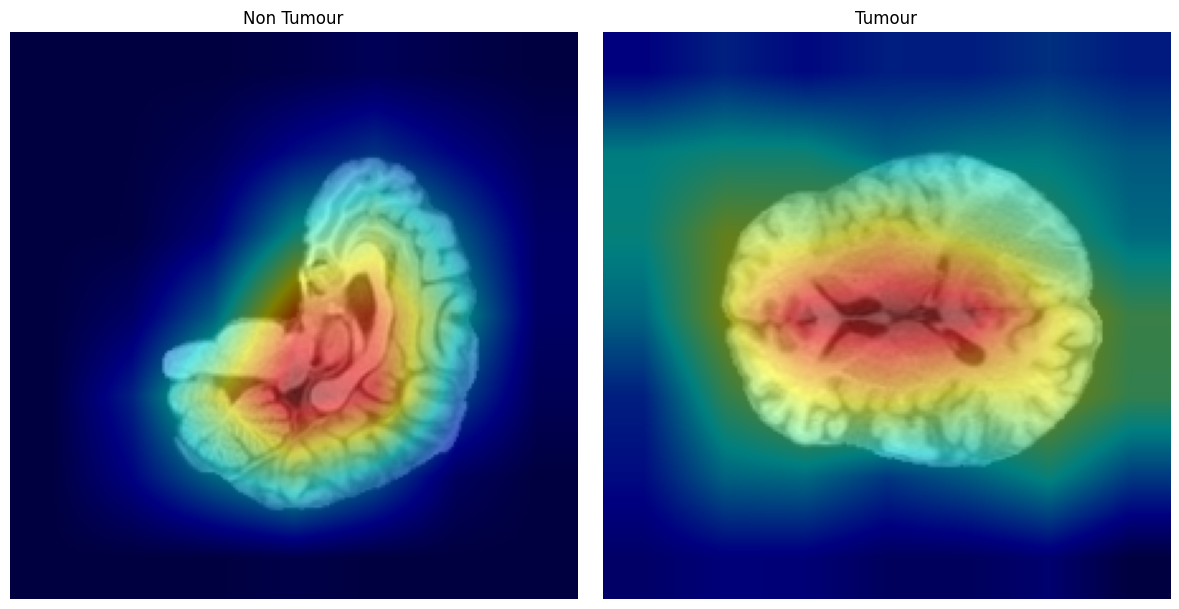

In [27]:
plt.figure(figsize=(12, 6))

# Non-Tumour on the left
plt.subplot(1, 2, 1)
plt.imshow(cam_image_non_tumour)
plt.title("Non Tumour")
plt.axis('off')

# Tumour on the right
plt.subplot(1, 2, 2)
plt.imshow(cam_image_tumour)
plt.title("Tumour")
plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
from sklearn.model_selection import KFold
import numpy as np

# First, group your data by subject using your subject-level grouping functions
subjects_dict = group_by_subject(file_label_list)
subject_ids = list(subjects_dict.keys())

# Set up 5-fold cross-validation on the unique subject IDs
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

fold = 1
for train_index, test_index in kf.split(subject_ids):
    print(f"\n--- Fold {fold} ---")
    # Get the subject IDs for train and test for this fold
    train_subjects = [subject_ids[i] for i in train_index]
    test_subjects  = [subject_ids[i] for i in test_index]
    
    # Build the train and test lists based on these subject IDs
    train_list_fold = []
    test_list_fold = []
    for sid in train_subjects:
        train_list_fold.extend(subjects_dict[sid])
    for sid in test_subjects:
        test_list_fold.extend(subjects_dict[sid])
    
    # Further split train_list_fold into train and validation (e.g., 90/10 split)
    random.shuffle(train_list_fold)
    n_train = int(0.9 * len(train_list_fold))
    fold_train_list = train_list_fold[:n_train]
    fold_val_list = train_list_fold[n_train:]
    
    # Create datasets and dataloaders for this fold
    fold_train_dataset = NiftiDataset(fold_train_list, transform=train_transforms)
    fold_val_dataset   = NiftiDataset(fold_val_list, transform=val_test_transforms)
    fold_test_dataset  = NiftiDataset(test_list_fold, transform=val_test_transforms)
    
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=16, shuffle=True)
    fold_val_loader   = DataLoader(fold_val_dataset, batch_size=16, shuffle=False)
    fold_test_loader  = DataLoader(fold_test_dataset, batch_size=16, shuffle=False)
    
    # Initialize a fresh model for this fold
    fold_model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
    num_features = fold_model.classifier.in_features
    fold_model.classifier = nn.Linear(num_features, 2)
    fold_model.to(device)
    
    # Set up loss, optimizer, and training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fold_model.parameters(), lr=1e-4)
    num_epochs = 50
    early_stop_patience = 10
    best_val_acc_fold = 0.0
    epochs_no_improve = 0
    
    # Training loop for this fold
    for epoch in range(num_epochs):
        fold_model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in fold_train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(fold_train_dataset)
        epoch_acc = running_corrects.double() / len(fold_train_dataset)
        
        # Validation Phase
        fold_model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in fold_val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(fold_val_dataset)
        val_epoch_acc = val_running_corrects.double() / len(fold_val_dataset)
        
        print(f"Fold {fold} - Epoch {epoch+1}: Train Acc: {epoch_acc:.4f} | Val Acc: {val_epoch_acc:.4f}")
        
        if val_epoch_acc > best_val_acc_fold:
            best_val_acc_fold = val_epoch_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping in Fold {fold} at epoch {epoch+1}")
            break

    print(f"Best Validation Accuracy for Fold {fold}: {best_val_acc_fold:.4f}")
    fold_accuracies.append(best_val_acc_fold.item())
    fold += 1

print("\n--- Cross-Validation Results ---")
print("Validation Accuracies per Fold:", fold_accuracies)
print("Average Validation Accuracy:", np.mean(fold_accuracies))
print("Standard Deviation of Validation Accuracy:", np.std(fold_accuracies))


--- Fold 1 ---
Fold 1 - Epoch 1: Train Acc: 0.9688 | Val Acc: 1.0000
Fold 1 - Epoch 2: Train Acc: 0.9965 | Val Acc: 1.0000
Fold 1 - Epoch 3: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 4: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 5: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 6: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 7: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 8: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 9: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 10: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 1 - Epoch 11: Train Acc: 1.0000 | Val Acc: 1.0000
Early stopping in Fold 1 at epoch 11
Best Validation Accuracy for Fold 1: 1.0000

--- Fold 2 ---
Fold 2 - Epoch 1: Train Acc: 0.9514 | Val Acc: 1.0000
Fold 2 - Epoch 2: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 2 - Epoch 3: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 2 - Epoch 4: Train Acc: 1.0000 | Val Acc: 1.0000
Fold 2 - Epoch 5: Train Acc: 0.9965 | Val Acc: 1.0000
Fold 2 - Epoch 6: Tra

In [33]:
# %% External Validation Code

# Define the paths to your external dataset folders
external_tumour_dir = r'C:\Users\Devshree Deshmukh\Downloads\Test\Tumour Data'
external_non_tumour_dir = r'C:\Users\Devshree Deshmukh\Downloads\Test\Non Tumour Data'

# Load file paths and labels for the external dataset
external_file_label_list = load_file_list(external_tumour_dir, external_non_tumour_dir)

# Create the external dataset using the same transforms used for validation/test
external_dataset = NiftiDataset(external_file_label_list, transform=val_test_transforms)

# Create a DataLoader for the external dataset
external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False)

# Load the best saved model weights (if not already loaded)
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model.eval()

# Evaluate on the external dataset
all_preds_ext = []
all_labels_ext = []

with torch.no_grad():
    for inputs, labels in external_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_ext.extend(preds.cpu().numpy())
        all_labels_ext.extend(labels.cpu().numpy())

external_accuracy = np.mean(np.array(all_preds_ext) == np.array(all_labels_ext))
print(f"External Test Accuracy: {external_accuracy:.4f}")

# Compute confusion matrix and classification report for external data
cm_ext = confusion_matrix(all_labels_ext, all_preds_ext)
print("External Confusion Matrix:")
print(cm_ext)

report_ext = classification_report(all_labels_ext, all_preds_ext, target_names=["Non Tumour", "Tumour"])
print("External Classification Report:")
print(report_ext)

External Test Accuracy: 1.0000
External Confusion Matrix:
[[3 0]
 [0 3]]
External Classification Report:
              precision    recall  f1-score   support

  Non Tumour       1.00      1.00      1.00         3
      Tumour       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [34]:
# Assume 'model' is your trained EfficientNet-B0 model
import torch

# Create a dummy input tensor with the same shape as your model expects (1, channels, height, width)
dummy_input = torch.randn(1, 1, 224, 224, device=device)

# Trace the model using the dummy input
traced_model = torch.jit.trace(model, dummy_input)

# Save the TorchScript model to a file
torch.jit.save(traced_model, 'final_tumor_recognition_model_script.pt')